<a href="https://colab.research.google.com/github/dcpatton/Structured-Data/blob/main/kdd_cup_1999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

Below is an exploration of a computer network intrusion detection dataset (https://www.kdd.org/kdd-cup/view/kdd-cup-1999). The original task was:

*to build a predictive model (i.e. a classifier) capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections.*

I'll demonstrate a few approaches.

In [1]:
import tensorflow as tf
import random

seed = 53 ## for some consistency
random.seed(seed)
tf.random.set_seed(seed)
tf.__version__

'2.8.2'

In [2]:
!curl http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz -o train_full.gz
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/corrected.gz -o test.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17.2M  100 17.2M    0     0  34.6M      0 --:--:-- --:--:-- --:--:-- 34.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1376k  100 1376k    0     0  4207k      0 --:--:-- --:--:-- --:--:-- 4207k


In [3]:
!gunzip train_full.gz
!gunzip test.gz

In [4]:
names = ['duration',
        'protocol_type',
        'service',
        'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'target'
]

In [5]:
import pandas as pd
train = pd.read_csv('train_full', names=names)
test = pd.read_csv('test', names=names)
train.shape, train.shape

((4898431, 42), (4898431, 42))

In [6]:
for c in train.columns:
  print(c + ' : ' + str(train[c].nunique()))

duration : 9883
protocol_type : 3
service : 70
flag : 11
src_bytes : 7195
dst_bytes : 21493
land : 2
wrong_fragment : 3
urgent : 6
hot : 30
num_failed_logins : 6
logged_in : 2
num_compromised : 98
root_shell : 2
su_attempted : 3
num_root : 93
num_file_creations : 42
num_shells : 3
num_access_files : 10
num_outbound_cmds : 1
is_host_login : 2
is_guest_login : 2
count : 512
srv_count : 512
serror_rate : 96
srv_serror_rate : 87
rerror_rate : 89
srv_rerror_rate : 76
same_srv_rate : 101
diff_srv_rate : 95
srv_diff_host_rate : 72
dst_host_count : 256
dst_host_srv_count : 256
dst_host_same_srv_rate : 101
dst_host_diff_srv_rate : 101
dst_host_same_src_port_rate : 101
dst_host_srv_diff_host_rate : 76
dst_host_serror_rate : 101
dst_host_srv_serror_rate : 100
dst_host_rerror_rate : 101
dst_host_srv_rerror_rate : 101
target : 23


In [7]:
assert train.num_outbound_cmds.nunique() == 1
assert test.num_outbound_cmds.nunique() == 1
train.drop('num_outbound_cmds', axis='columns', inplace=True)
test.drop('num_outbound_cmds', axis='columns', inplace=True)

In [8]:
cols = list(train.columns)
cols.remove('target')
dummy_cols = []
for c in cols:
  if train[c].nunique() < 12:
    if train[c].nunique() != test[c].nunique():
      print(c)
    else:
      dummy_cols.append(c)
dummy_cols.remove('is_host_login')
dummy_cols.remove('is_guest_login')
dummy_cols.remove('land')
dummy_cols.remove('logged_in')
dummy_cols.remove('root_shell')
train = pd.get_dummies(train, columns=dummy_cols)
test = pd.get_dummies(test, columns=dummy_cols)

urgent
num_failed_logins
num_shells
num_access_files


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 57 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   service                      object 
 2   src_bytes                    int64  
 3   dst_bytes                    int64  
 4   land                         int64  
 5   urgent                       int64  
 6   hot                          int64  
 7   num_failed_logins            int64  
 8   logged_in                    int64  
 9   num_compromised              int64  
 10  root_shell                   int64  
 11  num_root                     int64  
 12  num_file_creations           int64  
 13  num_shells                   int64  
 14  num_access_files             int64  
 15  is_host_login                int64  
 16  is_guest_login               int64  
 17  count                        int64  
 18  srv_count                    int64  
 19  

In [10]:
train.service.value_counts()

ecr_i        2811660
private      1100831
http          623091
smtp           96554
other          72653
              ...   
tftp_u             3
harvest            2
aol                2
http_8001          2
http_2784          1
Name: service, Length: 70, dtype: int64

In [11]:
test.service.value_counts()

ecr_i      164352
private     78510
http        41237
smtp         8268
pop_3        3972
            ...  
pm_dump        16
X11            15
tim_i           7
icmp            2
tftp_u          1
Name: service, Length: 65, dtype: int64

In [12]:
# difference in service column values between train and test

s = set(train.service.unique())
temp = [x for x in test.service.unique() if x not in s]
print('not in train')
print(temp)
s = set(test.service.unique())
temp = [x for x in train.service.unique() if x not in s]
print('not in test')
print(temp)

not in train
['icmp']
not in test
['urh_i', 'http_2784', 'harvest', 'aol', 'http_8001', 'red_i']


In [13]:
print(test[test['service'] == 'icmp'].shape[0])
print(train[train['service'] == 'urh_i'].shape[0])
print(train[train['service'] == 'http_2784'].shape[0])
print(train[train['service'] == 'harvest'].shape[0])
print(train[train['service'] == 'aol'].shape[0])
print(train[train['service'] == 'http_8001'].shape[0])
print(train[train['service'] == 'red_i'].shape[0])

2
148
1
2
2
2
9


In [14]:
# group these odd ones as other. another approach would be to drop them
test.loc[test['service'] == 'icmp', 'service'] = 'other'
train.loc[train['service'] == 'urh_i', 'service'] = 'other'
train.loc[train['service'] == 'http_2784', 'service'] = 'other'
train.loc[train['service'] == 'harvest', 'service'] = 'other'
train.loc[train['service'] == 'aol', 'service'] = 'other'
train.loc[train['service'] == 'http_8001', 'service'] = 'other'
train.loc[train['service'] == 'red_i', 'service'] = 'other'

In [15]:
assert train.service.nunique() == test.service.nunique()
train.service.nunique()

64

In [16]:
test.service.value_counts()

ecr_i      164352
private     78510
http        41237
smtp         8268
pop_3        3972
            ...  
IRC            24
pm_dump        16
X11            15
tim_i           7
tftp_u          1
Name: service, Length: 64, dtype: int64

In [17]:
train.service.value_counts()

ecr_i      2811660
private    1100831
http        623091
smtp         96554
other        72817
            ...   
IRC            521
X11            135
tim_i           12
pm_dump          5
tftp_u           3
Name: service, Length: 64, dtype: int64

In [18]:
train.loc[train['service'] == 'tftp_u', 'service'] = 'other'
train.loc[train['service'] == 'tim_i', 'service'] = 'other'
train.loc[train['service'] == 'pm_dump', 'service'] = 'other'
test.loc[test['service'] == 'tftp_u', 'service'] = 'other'
test.loc[test['service'] == 'tim_i', 'service'] = 'other'
test.loc[test['service'] == 'pm_dump', 'service'] = 'other'

In [19]:
train = pd.get_dummies(train, columns=['service'])
test = pd.get_dummies(test, columns=['service'])

In [20]:
train.shape

(4898431, 117)

In [21]:
print(train.target.nunique())
print(test.target.nunique())

23
38


In [22]:
# create a set of sample for outcomes never seen in training
new_test = test.copy(deep=True)
for outcome in train.target.unique():
  new_test = new_test[new_test['target'] != outcome]
new_test.shape

(18729, 117)

In [23]:
new_test.target.value_counts()

snmpgetattack.    7741
mailbomb.         5000
snmpguess.        2406
mscan.            1053
apache2.           794
processtable.      759
saint.             736
httptunnel.        158
sendmail.           17
named.              17
ps.                 16
xterm.              13
xlock.               9
xsnoop.              4
udpstorm.            2
worm.                2
sqlattack.           2
Name: target, dtype: int64

In [24]:
train.loc[train['target'] != 'normal.', 'target'] = 1
train.loc[train['target'] == 'normal.', 'target'] = 0
test.loc[test['target'] != 'normal.', 'target'] = 1
test.loc[test['target'] == 'normal.', 'target'] = 0
train['target'] = train['target'].astype(int)
test['target'] = test['target'].astype(int)
new_test['target'] = 1
new_test['target'] = new_test['target'].astype(int)

In [25]:
display((train.target.value_counts()[1]/train.shape[0])*100)
display((test.target.value_counts()[1]/test.shape[0])*100)

80.14096758737644

80.51853685669182

In [26]:
x_train = train.drop('target', axis='columns')
y_train = train.target
x_test = test.drop('target', axis='columns')
y_test = test.target
x_new_test = new_test.drop('target', axis='columns')
y_new_test = new_test.target

# IsolationForest

In [27]:
%%time
from sklearn.ensemble import IsolationForest
model = IsolationForest(n_jobs=1, random_state=seed)
model.fit(x_train, y_train)

CPU times: user 4min 4s, sys: 3.68 s, total: 4min 7s
Wall time: 4min 7s


In [28]:
%%time
y_pred = model.predict(x_test)

CPU times: user 22.8 s, sys: 193 ms, total: 23 s
Wall time: 22.9 s


In [29]:
y_pred = pd.Series(y_pred)
y_pred[y_pred==-1] = 0

In [30]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
auprc.result().numpy()

0.7799263

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.24      0.17     60593
           1       0.77      0.63      0.69    250436

    accuracy                           0.55    311029
   macro avg       0.45      0.43      0.43    311029
weighted avg       0.65      0.55      0.59    311029



In [32]:
y_pred = model.predict(x_new_test)
y_pred = pd.Series(y_pred)
y_pred[y_pred==-1] = 0

In [33]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_new_test, y_pred)
auprc.result().numpy()

1.0

In [34]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_new_test, y_pred)
m.result().numpy()

0.29836082

In [35]:
print(classification_report(y_new_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.30      0.46     18729

    accuracy                           0.30     18729
   macro avg       0.50      0.15      0.23     18729
weighted avg       1.00      0.30      0.46     18729



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XGBoost

10% of training data due to memory limit

In [36]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=.1, stratify=train.target, random_state=seed)
train.shape, val.shape, test.shape

((4408587, 117), (489844, 117), (311029, 117))

In [37]:
train_10 = train.sample(frac=0.1, random_state=seed)
train_10.shape

(440859, 117)

In [38]:
x_train = train_10.drop('target', axis='columns')
y_train = train_10.target
x_val = val.drop('target', axis='columns')
y_val = val.target
x_test = test.drop('target', axis='columns')
y_test = test.target

In [39]:
import xgboost as xgb
xgb.__version__

'0.90'

In [40]:
model = xgb.XGBClassifier(random_state=seed, tree_method='gpu_hist')
model.fit(x_train, y_train, eval_metric='aucpr', eval_set=[(x_train, y_train), (x_val, y_val)])

[0]	validation_0-aucpr:0.99948	validation_1-aucpr:0.999497
[1]	validation_0-aucpr:0.99948	validation_1-aucpr:0.999497
[2]	validation_0-aucpr:0.999928	validation_1-aucpr:0.999927
[3]	validation_0-aucpr:0.999928	validation_1-aucpr:0.999927
[4]	validation_0-aucpr:0.999933	validation_1-aucpr:0.999929
[5]	validation_0-aucpr:0.999934	validation_1-aucpr:0.99993
[6]	validation_0-aucpr:0.999938	validation_1-aucpr:0.999933
[7]	validation_0-aucpr:0.999938	validation_1-aucpr:0.999933
[8]	validation_0-aucpr:0.999939	validation_1-aucpr:0.999934
[9]	validation_0-aucpr:0.999939	validation_1-aucpr:0.999934
[10]	validation_0-aucpr:0.999938	validation_1-aucpr:0.999934
[11]	validation_0-aucpr:0.999939	validation_1-aucpr:0.999934
[12]	validation_0-aucpr:0.999948	validation_1-aucpr:0.99994
[13]	validation_0-aucpr:0.999968	validation_1-aucpr:0.999958
[14]	validation_0-aucpr:0.999967	validation_1-aucpr:0.999957
[15]	validation_0-aucpr:0.999988	validation_1-aucpr:0.999979
[16]	validation_0-aucpr:0.999988	valid

XGBClassifier(random_state=53, tree_method='gpu_hist')

In [41]:
y_pred = model.predict(x_test)

In [42]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
auprc.result().numpy()

0.9892779

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029



In [44]:
y_pred = model.predict(x_new_test)

In [45]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_new_test, y_pred)
auprc.result().numpy()

1.0

In [46]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_new_test, y_pred)
m.result().numpy()

0.08494847

In [47]:
print(classification_report(y_new_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.08      0.16     18729

    accuracy                           0.08     18729
   macro avg       0.50      0.04      0.08     18729
weighted avg       1.00      0.08      0.16     18729



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DNN

In [48]:
x_train = train.drop('target', axis='columns')
y_train = train.target

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
x_new_test = scaler.transform(x_new_test)

In [50]:
tf.keras.backend.clear_session()

inp = tf.keras.Input(shape=(x_train.shape[1],))
x = tf.keras.layers.Dense(512, activation='swish')(inp)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)
x = tf.keras.layers.Dense(512, activation='swish')(x)

out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 116)]             0         
                                                                 
 dense (Dense)               (None, 512)               59904     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 512)               262656

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='bce',
              metrics=[tf.keras.metrics.AUC(curve='PR')])
es = tf.keras.callbacks.EarlyStopping(patience=9, verbose=1, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=500, callbacks=[es], verbose=2,
                    validation_data=(x_val, y_val), batch_size=512)

Epoch 1/500
8611/8611 - 54s - loss: 0.0461 - auc: 0.9996 - val_loss: 0.0016 - val_auc: 1.0000 - 54s/epoch - 6ms/step
Epoch 2/500
8611/8611 - 50s - loss: 0.0286 - auc: 0.9998 - val_loss: 0.0021 - val_auc: 0.9999 - 50s/epoch - 6ms/step
Epoch 3/500
8611/8611 - 50s - loss: 0.0240 - auc: 0.9997 - val_loss: 0.0016 - val_auc: 1.0000 - 50s/epoch - 6ms/step
Epoch 4/500
8611/8611 - 50s - loss: 0.0661 - auc: 0.9997 - val_loss: 0.0018 - val_auc: 1.0000 - 50s/epoch - 6ms/step
Epoch 5/500
8611/8611 - 50s - loss: 0.0122 - auc: 0.9999 - val_loss: 0.0100 - val_auc: 0.9998 - 50s/epoch - 6ms/step
Epoch 6/500
8611/8611 - 50s - loss: 0.0416 - auc: 0.9999 - val_loss: 0.0333 - val_auc: 0.9985 - 50s/epoch - 6ms/step
Epoch 7/500
8611/8611 - 49s - loss: 0.0195 - auc: 0.9998 - val_loss: 0.0028 - val_auc: 1.0000 - 49s/epoch - 6ms/step
Epoch 8/500
8611/8611 - 50s - loss: 0.0470 - auc: 0.9999 - val_loss: 0.0049 - val_auc: 1.0000 - 50s/epoch - 6ms/step
Epoch 9/500
8611/8611 - 50s - loss: 0.0121 - auc: 1.0000 - val_l

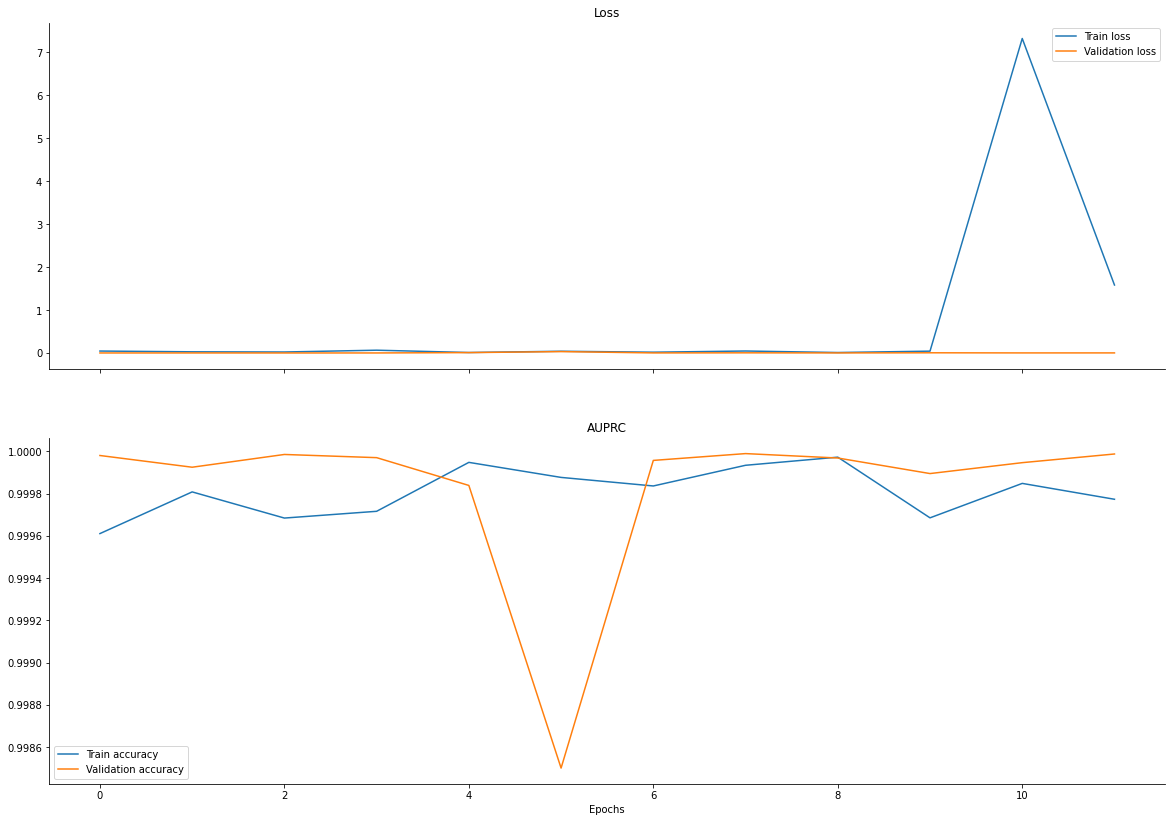

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auc'], label='Train accuracy')
ax2.plot(history['val_auc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [53]:
model.evaluate(x_test, y_test)

9720/9720 [==============================] - 36s 4ms/step - loss: 3.7501 - auc: 0.9881


[3.750112533569336, 0.9880948662757874]

In [54]:
y_pred = model.predict(x_test)

In [55]:
import numpy as np
y_pred = [y_pred > 0.5]
y_pred = np.multiply(y_pred, 1)[0]

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.98      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.89    311029
weighted avg       0.94      0.93      0.93    311029



In [57]:
model.evaluate(x_new_test, y_new_test)

586/586 [==============================] - 2s 4ms/step - loss: 19.6314 - auc: 1.0000


[19.631364822387695, 0.9999999403953552]

In [58]:
y_pred = model.predict(x_new_test)
y_pred = [y_pred > 0.5]
y_pred = np.multiply(y_pred, 1)[0]

In [59]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_new_test, y_pred)
m.result().numpy()

0.120027766

In [60]:
print(classification_report(y_new_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.12      0.21     18729

    accuracy                           0.12     18729
   macro avg       0.50      0.06      0.11     18729
weighted avg       1.00      0.12      0.21     18729



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Autoencoder

In [61]:
tf.keras.backend.clear_session()
inp = tf.keras.Input(shape=(x_train.shape[1],))
x = tf.keras.layers.Dense(256, activation='swish')(inp)
x = tf.keras.layers.Dense(200, activation='swish')(x)
x = tf.keras.layers.Dense(166, activation='swish')(x)
x = tf.keras.layers.Dense(133, activation='swish')(x)

enc = tf.keras.layers.Dense(100, activation='swish')(x)

x = tf.keras.layers.Dense(105, activation='swish')(enc)
x = tf.keras.layers.Dense(110, activation='swish')(x)
out = tf.keras.layers.Dense(x_train.shape[1])(x)

model = tf.keras.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 116)]             0         
                                                                 
 dense (Dense)               (None, 256)               29952     
                                                                 
 dense_1 (Dense)             (None, 200)               51400     
                                                                 
 dense_2 (Dense)             (None, 166)               33366     
                                                                 
 dense_3 (Dense)             (None, 133)               22211     
                                                                 
 dense_4 (Dense)             (None, 100)               13400     
                                                                 
 dense_5 (Dense)             (None, 105)               10605 

In [62]:
x_train_f = train[train['target'] == 0].drop('target', axis='columns')
x_val_f = val[val['target'] == 0].drop('target', axis='columns')
x_val_t = val[val['target'] == 1].drop('target', axis='columns')

In [63]:
x_train_f = scaler.transform(x_train_f)
x_val_f = scaler.transform(x_val_f)
x_val_t = scaler.transform(x_val_t)

In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mse',
              metrics=['mae'])
es = tf.keras.callbacks.EarlyStopping(patience=19, verbose=1, restore_best_weights=True)
history = model.fit(x_train_f, x_train_f, epochs=500, callbacks=[es], verbose=2,
                    validation_data=(x_val_f, x_val_f), batch_size=512)

Epoch 1/500
1710/1710 - 7s - loss: 0.6820 - mae: 0.1725 - val_loss: 0.1679 - val_mae: 0.1020 - 7s/epoch - 4ms/step
Epoch 2/500
1710/1710 - 6s - loss: 0.2526 - mae: 0.0952 - val_loss: 0.1091 - val_mae: 0.0912 - 6s/epoch - 4ms/step
Epoch 3/500
1710/1710 - 6s - loss: 0.1895 - mae: 0.0763 - val_loss: 0.0843 - val_mae: 0.0923 - 6s/epoch - 4ms/step
Epoch 4/500
1710/1710 - 6s - loss: 0.1620 - mae: 0.0673 - val_loss: 0.1198 - val_mae: 0.1151 - 6s/epoch - 4ms/step
Epoch 5/500
1710/1710 - 6s - loss: 0.1307 - mae: 0.0642 - val_loss: 0.0995 - val_mae: 0.0975 - 6s/epoch - 4ms/step
Epoch 6/500
1710/1710 - 6s - loss: 0.1075 - mae: 0.0627 - val_loss: 0.0382 - val_mae: 0.0547 - 6s/epoch - 4ms/step
Epoch 7/500
1710/1710 - 6s - loss: 0.0930 - mae: 0.0588 - val_loss: 0.0407 - val_mae: 0.0522 - 6s/epoch - 4ms/step
Epoch 8/500
1710/1710 - 6s - loss: 0.0771 - mae: 0.0588 - val_loss: 0.0355 - val_mae: 0.0522 - 6s/epoch - 4ms/step
Epoch 9/500
1710/1710 - 6s - loss: 0.0660 - mae: 0.0570 - val_loss: 0.0283 - val

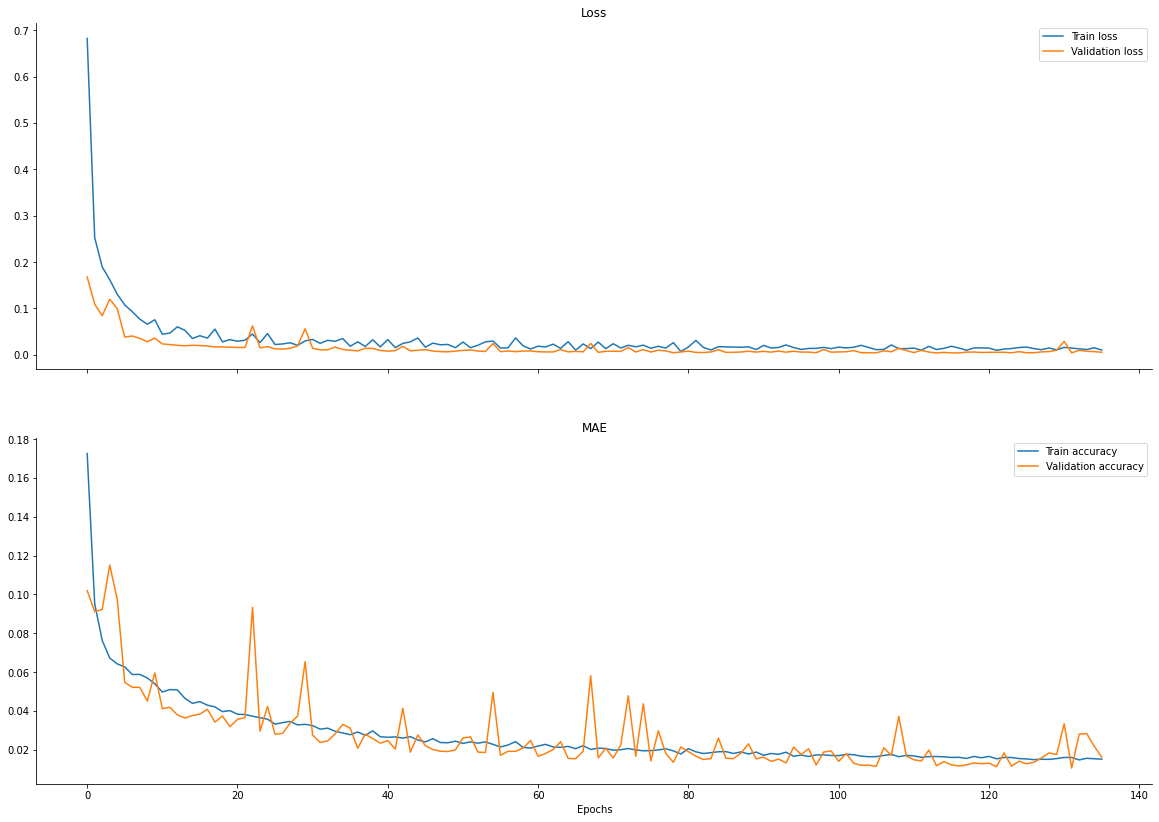

In [65]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Train accuracy')
ax2.plot(history['val_mae'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [66]:
model.evaluate(x_val_f, x_val_f)
model.evaluate(x_val_t, x_val_t)

12268/12268 [==============================] - 32s 3ms/step - loss: 0.7341 - mae: 0.2031


[0.734142541885376, 0.20306697487831116]

In [67]:
reconstructions_f = model.predict(x_val_f)
reconstructions_t = model.predict(x_val_t)

In [68]:
import numpy as np
mse_f = np.mean(np.power(x_val_f - reconstructions_f, 2), axis=1)
mse_t = np.mean(np.power(x_val_t - reconstructions_t, 2), axis=1)
print(mse_f.mean())
print(mse_t.mean())

0.00403395613732312
0.7341419450621192


In [69]:
print(np.median(mse_f))
print(np.median(mse_t))

8.003479550289171e-05
0.0993583710635706


In [70]:
reconstructions = model.predict(x_test)
mse = np.mean(np.power(x_test - reconstructions, 2), axis=1)

In [71]:
y_pred = [mse > 0.001]
y_pred = np.multiply(y_pred, 1)[0]

In [72]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
auprc.result().numpy()

0.97867197

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.89     60593
           1       0.98      0.96      0.97    250436

    accuracy                           0.95    311029
   macro avg       0.91      0.94      0.93    311029
weighted avg       0.96      0.95      0.95    311029



In [74]:
reconstructions = model.predict(x_new_test)
mse = np.mean(np.power(x_new_test - reconstructions, 2), axis=1)

In [75]:
y_pred = [mse > 0.001]
y_pred = np.multiply(y_pred, 1)[0]

In [76]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_new_test, y_pred)
auprc.result().numpy()

1.0

In [77]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_new_test, y_pred)
m.result().numpy()

0.44818196

In [78]:
print(classification_report(y_new_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.45      0.62     18729

    accuracy                           0.45     18729
   macro avg       0.50      0.22      0.31     18729
weighted avg       1.00      0.45      0.62     18729



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Summary

* XGBoost does a great job out of the box and there are ways to overcome the memory limitation for large datasets
* The autoencoder could be tuned to be a lot better, but is clearly the best at detecting new types of outliers. (top accuracy on x_new_test data)



---

In [79]:
#bonus
train_10 = train.sample(frac=0.1, random_state=seed)
x_train = train_10.drop('target', axis='columns')
y_train = train_10.target

encoder = tf.keras.Model(inp, enc)
x_train_encoded = encoder.predict(x_train)
x_val_encoded = encoder.predict(x_val)
x_test_encoded = encoder.predict(x_test)
x_new_test_encoded = encoder.predict(x_new_test)

In [80]:
model = xgb.XGBClassifier(random_state=seed, tree_method='gpu_hist', n_estimators=100, learning_rate=0.01)
model.fit(x_train_encoded, y_train, eval_metric='aucpr', eval_set=[(x_train_encoded, y_train), (x_val_encoded, y_val)])

[0]	validation_0-aucpr:0.999333	validation_1-aucpr:0.666813
[1]	validation_0-aucpr:0.999334	validation_1-aucpr:0.668714
[2]	validation_0-aucpr:0.999334	validation_1-aucpr:0.668714
[3]	validation_0-aucpr:0.999334	validation_1-aucpr:0.668714
[4]	validation_0-aucpr:0.999334	validation_1-aucpr:0.668714
[5]	validation_0-aucpr:0.999334	validation_1-aucpr:0.668714
[6]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743177
[7]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743177
[8]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743265
[9]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743265
[10]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743265
[11]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743265
[12]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743265
[13]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743265
[14]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743265
[15]	validation_0-aucpr:0.999337	validation_1-aucpr:0.743265
[16]	validation_0-aucpr:0.999337	v

XGBClassifier(learning_rate=0.01, random_state=53, tree_method='gpu_hist')

In [81]:
y_pred = model.predict(x_test_encoded)

In [82]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
auprc.result().numpy()

0.8215743

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.97      0.33     60593
           1       0.90      0.06      0.11    250436

    accuracy                           0.24    311029
   macro avg       0.55      0.52      0.22    311029
weighted avg       0.76      0.24      0.16    311029



In [84]:
y_pred = model.predict(x_new_test_encoded)

In [85]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_new_test, y_pred)
auprc.result().numpy()

1.0

In [86]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_new_test, y_pred)
m.result().numpy()

0.011052378

In [87]:
print(classification_report(y_new_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.01      0.02     18729

    accuracy                           0.01     18729
   macro avg       0.50      0.01      0.01     18729
weighted avg       1.00      0.01      0.02     18729



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
